This script is used to produce Figures 3 (validation of CESM seasonal cycle of NPP) and 4 (validation of spatial patterns of NPP) for the Payne et al. paper "Quantifying the potential predictability of Arctic primary production".

1. Import packages

In [1]:
import numpy as np
from pyhdf.SD import SD, SDC
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import xarray as xr
from PIL import Image
from glob import glob
import pandas as pd

2. Read in NPP from the Lewis et al. (2020) Arctic algorithm for years 2005-2014. Use this to prepare data for Figure 3 and to plot Figure 4b.

In [2]:
unitconv = 1.55
fdir = "/glade/campaign/cesm/development/pcwg/Arc_Sat_NPP/"
sat_npp = np.zeros([10,365,2325,2014])
i = -1
for yr in np.arange(2005,2015):
    i = i + 1
    fnam = str(yr) + '_50N_Reg_v3_A_R20180.nc'
    ncfile1 = xr.open_dataset(fdir + fnam)
    sat_npp[i,:,:,:] =ncfile1["NPP"][0:365,:,:]


Get rid of NPP below 66.5°N (algorithm has not been validated south of there) and pixels with no observations.

In [3]:
arc_npp = np.full([10,365,2325,2014],np.nan)
for i in np.arange(0,2325):
    for j in np.arange(0,2014):
        if ncfile1['LAT'][i,j] > 66.5:
            arc_npp[:,:,i,j] = sat_npp[:,:,i,j]

In [4]:
arc_npp = np.nan_to_num(arc_npp, nan=0)

Sum daily NPP for each month for 2005-2014. Also calculate the mean annually integrated NPP at each grid cell (arc_npp_mean).

In [5]:
dpermon = [31,28,31,30,31,30,31,31,30,31,30,31]
arc_monnpp = np.zeros([10,12,2325,2014])

for yr in np.arange(0,10):
    m = 0; m2 = 1; d1 = -1
    for d in np.arange(0,365):
        d1 = d1 + 1
        if d1 == np.sum(dpermon[0:m2]):
            m2 = m2 + 1
            m = m + 1
        arc_monnpp[yr,m,:,:] = arc_npp[yr,d,:,:] + arc_monnpp[yr,m,:,:]

In [6]:
totnpp = np.zeros([10,12])
totnpp = np.nansum(np.nansum(arc_monnpp,axis=2),axis=2)

In [289]:
arc_npp_mean = np.nanmean(np.nansum(arc_npp,axis=1),axis=0)
arc_npp_mean = np.where(arc_npp_mean==0, np.nan, arc_npp_mean)

Plot Figure 4b - Annually averaged NPP from the Lewis et al. algorithm.

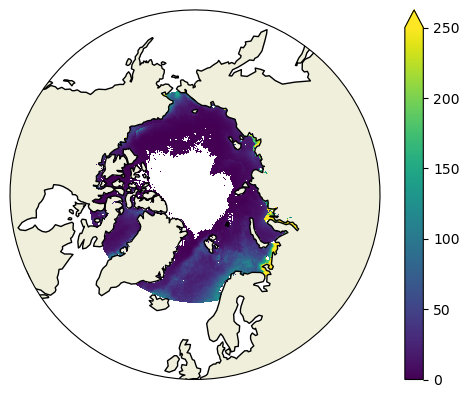

In [492]:
# plt.figure(figsize=(3,3)) #plt.figure(figsize=(2.5,2.5))
import matplotlib.path as mpath
import cmocean
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

pc = ax.pcolormesh(ncfile1['LON'], ncfile1['LAT'], arc_npp_mean/1e3*unitconv,transform=ccrs.PlateCarree(), vmin = 0, vmax = 250)#, cmap = 'cmo.matter_r');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc,extend='max');

# # d. Write out that figure
figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/validmapa2.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

3. Read in NPP files for diatom, diazotroph, and small phytoplankton functional types (photoC_diat_zint, photoC_diaz_zint, and photoC_sp_zint, respectively) from the CESM2-LE for years 2005-2014. Mean, standard deviation, and variance in NPP is calculated for each model grid cell and across all ensemble members.

In [8]:
# a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_100m', 'photoC_diaz_zint_100m', 'photoC_sp_zint_100m']
dat_clim = np.full([50, 60, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1

# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*200001*"):
        i = i + 1

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values 

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,60):
                dat_clim[i,t,:,:] = dat[t+60,:,:]
        else:
            for t in range(0,60):
                dat_clim[i,t,:,:] = dat[t+60,:,:] + dat_clim[i,t,:,:]


In [232]:
# a. Select variable of interest and locate the files
vdir = 'ocn' # 'ocn' or 'ice'
vnam = ['photoC_diat_zint_100m', 'photoC_diaz_zint_100m', 'photoC_sp_zint_100m']
dat_clim2 = np.full([50, 60, 384, 320], np.nan)
for j in np.arange(0,len(vnam)):
    fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/month_1/' + vnam[j] + '/'

# b. Make an array of nans to store the values from all EMs
    i = -1

# c. Loop through all the files in the directory, storing data in dat_clim
    for file in glob.glob(fdir + "*smbb*201001*"):
        i = i + 1

# d. Open the netcdf and store the variable of interest as dat. Also open lon and lat.
        ncfile = xr.open_dataset(file) 
        dat = ncfile[vnam[j]].values
        lon, lat = ncfile.TLONG.values, ncfile.TLAT.values 

# e. Interpolate lat and lon values over holes in the arrays
        ok = ~np.isnan(lon)
        xp = ok.ravel().nonzero()[0]
        fp = lon[~np.isnan(lon)]
        x  = np.isnan(lon).ravel().nonzero()[0]
        lon[np.isnan(lon)] = np.interp(x, xp, fp)

        ok = ~np.isnan(lat)
        xp = ok.ravel().nonzero()[0]
        fp = lat[~np.isnan(lat)]
        x  = np.isnan(lat).ravel().nonzero()[0]
        lat[np.isnan(lat)] = np.interp(x, xp, fp)

# f. Loop through the ensemble members, assigning each to its own column.
        if j == 0:
            for t in range(0,60):
                dat_clim2[i,t,:,:] = dat[t,:,:]
        else:
            for t in range(0,60):
                dat_clim2[i,t,:,:] = dat[t,:,:] + dat_clim2[i,t,:,:]


Use all 500 simulations (10 years * 50 ensemble members) to calculate a climatological mean and S.D.

In [10]:

dat_climt = np.full([500, 384, 320], np.nan)
clim = np.full([12, 384, 320], np.nan)
clim_sd = np.full([12, 384, 320], np.nan)
    
for t in range(0,12):
    dat_climt[0:50,:,:] = dat_clim[:,t,:,:]
    dat_climt[50:100,:,:] = dat_clim[:,t + 12,:,:]
    dat_climt[100:150,:,:] = dat_clim[:,t + 24,:,:]
    dat_climt[150:200,:,:] = dat_clim[:,t + 36,:,:]
    dat_climt[200:250,:,:] = dat_clim[:,t + 48,:,:]
    dat_climt[250:300,:,:] = dat_clim2[:,t,:,:]
    dat_climt[300:350,:,:] = dat_clim2[:,t + 12,:,:]
    dat_climt[350:400,:,:] = dat_clim2[:,t + 24,:,:]
    dat_climt[400:450,:,:] = dat_clim2[:,t + 36,:,:]
    dat_climt[450:500,:,:] = dat_clim2[:,t + 48,:,:]
    
    clim[t,:,:] = (np.nansum(dat_climt, axis = 0)) / 500
    clim_sd[t,:,:] = np.nanstd(dat_climt, axis = 0)
  

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


4. Calculate the area of each grid cell in the Arctic (here, >66.5°N). This variable is used to scale NPP by area and also to exclude sub-Arctic grid cells.

In [394]:
# b. Open up the areacello (area for ocean grid cells) file. I'll use this to calculate sea ice areal coverage
clim1 = xr.open_dataset("/glade/u/home/cpayne/Projects/PredictPerfect/CESM2_clims/NPP_clim.nc")

acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files
areacello_ocn = np.full([384,320], np.nan)
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(clim_sd[5,i,j]) == False and ncfile["TLAT"][i,j] > 66.5:
            areacello_ocn[i,j] = areacello[i,j]


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


5. Sum the mean and standard deviation in NPP across the Arctic by month (for use in Fig. 3), using dpm to calculate the days in each month and areacello_ocn to account for the differential area represented by each grid cell.

In [12]:
dpm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [395]:
clim_arc, clim_arc_sd = np.zeros(12), np.zeros(12)

unit = 'NPP (Tg C m^{-2} month^^{-1})'#'log(NPP) log(g C m-2 d-1) * million km2'; 
unitconv = 10.377 /1e12# # mmol C m-3 cm s-1 converted to g C m-2 d-1
# m2 converted to km2, km2 converted to million km2

for t in np.arange(0,12,1):
    clim_arc[t] = np.nansum(clim[t,:,:]* areacello_ocn ) * unitconv * dpm[t]
    clim_arc_sd[t] = np.nansum(clim_sd[t,:,:]* areacello_ocn ) * unitconv * dpm[t]

Plot Figure 4a - Annually averaged NPP from the model

/glade/derecho/scratch/cpayne/tmp/ipykernel_55444/569087677.py:17: RuntimeWarning: Mean of empty slice
  pc = ax.pcolormesh(lon, lat, np.nanmean(climsum*365*10.377,axis=0),transform=ccrs.PlateCarree(), vmin = 0, vmax = 250)#, cmap = 'cmo.matter_r');


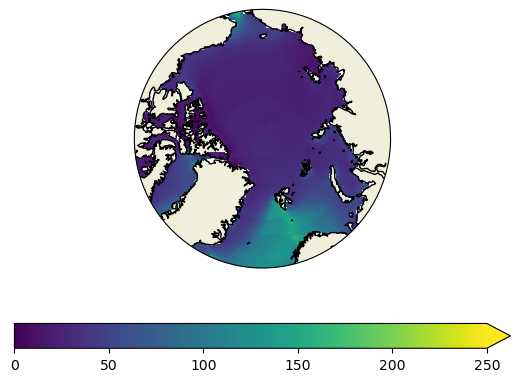

In [393]:
# make circular boundary for polar stereographic circular plots
climsum = np.where(clim==0, np.nan, clim)

# plt.figure(figsize=(3,3)) #plt.figure(figsize=(2.5,2.5))
import matplotlib.path as mpath
import cmocean
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 66.5, 90], crs = ccrs.PlateCarree());

pc = ax.pcolormesh(lon, lat, np.nanmean(climsum*365*10.377,axis=0),transform=ccrs.PlateCarree(), vmin = 0, vmax = 250)#, cmap = 'cmo.matter_r');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc,extend='max', orientation = 'horizontal');

# d. Write out that figure
figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/validmapcbar2.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

6. Read in NPP from the VPGM algorithm. Use this to create Figure 4c and to prepare data for Figure 3.

In [2]:
files = sorted(glob(f'/glade/work/kristenk/satellite_data/VGPM/netcdf/vgpm.???????.all.nc'))       
ds_vgpm = xr.open_mfdataset(files, concat_dim="time", combine='nested').compute()

In [9]:
ds_vgpm = ds_vgpm.where(ds_vgpm > -9999.)

In [10]:
time = pd.date_range(start="2003-01-01", end="2022-01-01",freq="M")
ds_vgpm['time']= time

In [11]:
%%time
ds_vgpm_ann = ds_vgpm.resample({'time':'A'}).mean(dim='time').compute()



CPU times: user 30.6 s, sys: 43.4 s, total: 1min 13s
Wall time: 1min 21s


In [12]:
ds_vgpm_mean = ds_vgpm_ann.mean(dim='time')

Calculate area of each grid cell for VGPM

In [13]:
area = xr.DataArray(np.zeros([2160,4320]), dims=('lat','lon'))

j=0

for lat in ds_vgpm_ann.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1./12. #res in degrees
    resolution_lon =1./12. #res in degrees

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_vgpm_ann['area']=area
ds_vgpm['area'] = area

Determine which cells are north of 66.5°N, and make a special array of just area for those cells.

In [18]:
for lat in np.arange(0,2160):
    if ds_vgpm['lat'].values[lat] > 66.5:
        print(lat)
        break
#lat >= 1878 is >66.5°N
#lat >= 1680 is >50°N

1878


In [ ]:
ds_vgpm_arc = np.full([10,12,2160,4320],np.nan)
ds_vgpm_area = np.full([2160,4320],np.nan)
# ds_vgpm_broad = np.full([10,12,282,4320],np.nan)
for yr in np.arange(2,12):
    t0 = yr*12
    t1 = (yr+1)*12
    ds_vgpm_arc[yr-2,:,1878:2160,:] = ds_vgpm['NPP'][t0:t1,1878:2160,:]
    # ds_vgpm_broad[yr-2,:,:,:] = ds_vgpm['NPP'][t0:t1,1680:2160,:]
ds_vgpm_area[1878:2160,:] = ds_vgpm['area'][1878:2160,:]

Plot annually averaged NPP for 2005-2014 for the VGPM algorithm (Figure 4c)

In [ ]:
ds_vgpm_mean_na = np.where(ds_vgpm_mean==0, np.nan, ds_vgpm_mean)

# plt.figure(figsize=(3,3)) #plt.figure(figsize=(2.5,2.5))
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 66.5, 90], crs = ccrs.PlateCarree());
# clim_ac = ma.masked_array(ds_vgpm_mean[:,:], ds_vgpm["lat"] < 50)
pc = ax.pcolormesh(ds_vgpm["lon"], ds_vgpm["lat"], ds_vgpm_mean_na/1e3,
                    transform=ccrs.PlateCarree(), vmin = 0, vmax = 100)#, cmap = 'cmo.matter_r');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc,extend='max');

# c. Plot the lines of the LMEs.
# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]
#     ax.plot(x,y,transform=ccrs.PlateCarree(),color='black',linewidth=1)

# d. Write out that figure
figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/validmapc.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

For 2005-2014, this integrates NPP in the Arctic (>66.5°N) in the VGPM for each month, which whill be used in Figure 3.

In [ ]:
for yy in np.arange(0,10):
    for mm in np.arange(0,12):
        inti = ds_vgpm_arc[yy,mm,:,:]*ds_vgpm_area*dpermon[mm]
        ds_vgpm_arc_sum[yy,mm] = np.nansum(inti)

7. Read in NPP from the CbPM algorithm. Use this to create Figure 4d and to prepare data for Figure 3.

In [24]:
%%time
files = sorted(glob(f'/glade/work/kristenk/satellite_data/CBPM/cbpm.???????.nc'))       
ds_cbpm = xr.open_mfdataset(files, concat_dim="time", combine='nested').compute()

CPU times: user 2.26 s, sys: 2.45 s, total: 4.71 s
Wall time: 17.9 s


In [26]:
times = len(ds_cbpm.time)

228

In [27]:
%%time 
### do first ts
tmp = np.flipud(ds_cbpm.npp.isel(time=0).values)
npp = xr.DataArray(tmp,dims=('lat','lon'))
    
## do the rest
for ts in np.arange(1,times,1):
    #print(ts)
    tmp = np.flipud(ds_cbpm.npp.isel(time=ts).values)
    tmp = xr.DataArray(tmp,dims=('lat','lon'))

    npp = xr.concat([npp,tmp],dim='time')

CPU times: user 41.6 s, sys: 43.2 s, total: 1min 24s
Wall time: 1min 26s


Set up CbPM NPP data in a dataset with lat, lon, and time.

In [29]:
ds_cbpm = xr.Dataset()
ds_cbpm['npp'] = npp

In [30]:
ds_cbpm['lat'] = np.arange(-90,90,1/6)
ds_cbpm['lon'] = np.arange(-180,180,1/6)

In [31]:
ds_cbpm['npp'] = ds_cbpm.npp.where(ds_cbpm.npp>0)

In [33]:
ds_cbpm['time' ]= time

Calculate area of each grid cell for CbPM.

In [48]:
area = xr.DataArray(np.zeros([1080,2160]), dims=('lat','lon'))

j=0

for lat in ds_cbpm_ann.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1./6. #res in degrees
    resolution_lon =1./6. #res in degrees

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_cbpm_ann['area']=area
ds_cbpm['area']=area

Determine which cells are north of 66.5°N, and make a special array of just area for those cells.

In [96]:
for lat in np.arange(0,1080):
    if ds_cbpm['lat'].values[lat] > 66.5:
        print(lat)
        break
#lat >= 939 is >66.5°N
#lat >= 840 is >50°N

939


In [437]:
ds_cbpm_arc = np.full([10,12,1080,2160],np.nan)
ds_cbpm_area = np.full([1080,2160],np.nan)
for yr in np.arange(2,12):
    t0 = yr*12
    t1 = (yr+1)*12
    ds_cbpm_arc[yr-2,:,939:1080,:] = ds_cbpm['npp'][t0:t1,939:1080,:]
    ds_cbpm_area[939:1080,:] = ds_cbpm['area'][939:1080,:]

For 2005-2014, this integrates NPP in the Arctic (>66.5°N) for each month.

In [475]:
for yy in np.arange(0,10):
    for mm in np.arange(0,12):
        int = ds_cbpm_arc[yy,mm,:,:]*ds_cbpm_area*dpermon[mm]
        ds_cbpm_arc_sum[yy,mm] = np.nansum(int)


In [ ]:
ds_cbpm_mean_na = np.where(ds_cbpm_mean==0, np.nan, ds_cbpm_mean)

# plt.figure(figsize=(3,3)) #plt.figure(figsize=(2.5,2.5))
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 66.5, 90], crs = ccrs.PlateCarree());

pc = ax.pcolormesh(ds_cbpm["lon"], ds_cbpm["lat"], ds_cbpm_mean_na/1e3,
                    transform=ccrs.PlateCarree(), vmin = 0, vmax = 100)#, cmap = 'cmo.matter_r');
ax.coastlines();  ax.add_feature(cfeature.LAND); plt.colorbar(pc,extend='max');

# d. Write out that figure
figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/validmapb.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

8. Plot Figure 3 - monthly Arctic Ocean (>66.5°N) NPP for 3 satellite algorithms for 2005-2014, compared to CESM2-LE mean and S.D. across 50 ensemble members for 2005-2014.

In [ ]:
ds_vgpm_mean = np.zeros([2160,4320])
ds_cbpm_mean = np.zeros([1080,2160])
for yr in np.arange(2,12):
    t0 = yr * 12
    t1 = (yr + 1) * 12
    ds_vgpm_mean = np.nansum(ds_vgpm['NPP'][t0:t1,:,:],axis=0) + ds_vgpm_mean
    ds_cbpm_mean = np.nansum(ds_cbpm['npp'][t0:t1,:,:],axis=0) + ds_cbpm_mean
ds_vgpm_mean = ds_vgpm_mean/10/12*365
ds_cbpm_mean = ds_cbpm_mean/10/12*365

In [ ]:
mons = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
coli = ['#003c30', '#01665e', 'teal', '#35978f','#80cdc1','#f6e8c3','#dfc27d','#bf812d','#8c510a','#543005']

plt.figure(figsize=(4.5,3))
plt.plot(np.arange(0,12), clim_arc[0:12], color = 'black', alpha = 0.8,linestyle = 'dashed'); #plt.xlabel('Month'), #plt.ylabel(unit)
plt.fill_between(np.arange(0,12),(clim_arc[0:12] - clim_arc_sd[0:12]), (clim_arc[0:12] + clim_arc_sd[0:12]), color = 'grey', alpha = 0.4)
for yr in np.arange(0,10):
    plt.plot(np.arange(0,12), totnpp[yr,:]*4*4*unitconv/1e9, color='darkblue')
    plt.plot(np.arange(0,12),ds_vgpm_arc_sum[yr,:]/1e9, color='forestgreen')
    plt.plot(np.arange(0,12),ds_cbpm_arc_sum[yr,:]/1e9, color='maroon')
plt.xlim(0,11)
plt.xticks(np.arange(0,12), mons);
figdir = '/glade/u/home/cpayne/Projects/PredictPerfect/Figures/PaperFigs/validationa.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()
